In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingRandomSearchCV
import optuna
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.preprocessing import MinMaxScaler


/root/miniconda3/envs/envPytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
def cross_val(model, x_df , y_df):
    pred = cross_val_score(model, x_df, y_df, cv=5, scoring='r2')
    return pred

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [3]:
df = pd.read_csv('listing_filtered.csv')
y = 'number_of_reviews_l30d'

y_df = df[y]
x_df = df.drop(y, axis=1)
# x_df = x_df.drop('number_of_reviews_l30d',axis=1)
# x_df = x_df.drop('reviews_per_month',axis=1)

X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.3, random_state=42)
X_train.shape

(7179, 71)

In [4]:
# default
rf_reg = RandomForestRegressor(n_estimators=200)
rf_reg.fit(X_train, y_train)

test_pred = rf_reg.predict(X_test)
train_pred = rf_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 0.8353233669158271
MSE: 1.508126909327267
RMSE: 1.2280581864583073
R2 Square 0.5917012738326595
Train set evaluation:
_____________________________________
MAE: 0.30747248920462456
MSE: 0.21059764939406603
RMSE: 0.45890919515092093
R2 Square 0.9440261979319998


In [5]:
# HalvingRandomSearchCV 
param_distributions = {
    'n_estimators': [50,100, 200, 300, 500],  # 树的数量
    'max_features': ['sqrt', 'log2'],  # 寻找最佳分割时要考虑的特征数量
    'max_depth': [5, 10, 20, 30, 40, 50],  # 树的最大深度
    'min_samples_split': [2, 5, 10],  # 内部节点再划分所需最小样本数
    'min_samples_leaf': [1, 2, 4],  # 在叶节点上所需的最小样本数
    'bootstrap': [True, False]  # 是否在建立树时使用放回抽样
}
rf = RandomForestRegressor()

# 设置 HalvingRandomSearchCV
search = HalvingRandomSearchCV(estimator=rf, param_distributions=param_distributions,
                               n_candidates=2000, factor=3, random_state=42, 
                               resource='n_samples', max_resources='auto', min_resources='smallest',
                               cv=5, verbose=1, scoring='neg_mean_squared_error',n_jobs=-1)

# 运行搜索
search.fit(X_train, y_train)

# 输出最佳参数和对应的性能
print("Best parameters:", search.best_params_)
print("Best score (MSE):", -search.best_score_)  # 转换成正的MSE，因为评分标准是负的MSE

# 使用最优参数训练的模型
best_model = search.best_estimator_

n_iterations: 6
n_required_iterations: 7
n_possible_iterations: 6
min_resources_: 10
max_resources_: 7179
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1080
n_resources: 10
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


/root/miniconda3/envs/envPytorch/lib/python3.8/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 1080 is smaller than n_iter=2000. Running 1080 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 360
n_resources: 30
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
----------
iter: 2
n_candidates: 120
n_resources: 90
Fitting 5 folds for each of 120 candidates, totalling 600 fits
----------
iter: 3
n_candidates: 40
n_resources: 270
Fitting 5 folds for each of 40 candidates, totalling 200 fits
----------
iter: 4
n_candidates: 14
n_resources: 810
Fitting 5 folds for each of 14 candidates, totalling 70 fits
----------
iter: 5
n_candidates: 5
n_resources: 2430
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}
Best score (MSE): 1.6519289002045212


In [6]:
# 基于超参数 ， train model
model = RandomForestRegressor(
    **search.best_params_
)

model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 0.8781991789128951
MSE: 1.5142070678686677
RMSE: 1.230531213691334
R2 Square 0.5900551782872543
Train set evaluation:
_____________________________________
MAE: 0.18452611000030097
MSE: 0.08695350204716629
RMSE: 0.2948787921285054
R2 Square 0.976889019764887


In [7]:
# optuna bayesian
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42
    }
    model =  RandomForestRegressor(**params)
    # Perform cross-validation with AUC as the scoring metric
    scores = -np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error',n_jobs=-1))
    return scores

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs=-1)


[I 2024-05-30 01:17:31,677] A new study created in memory with name: no-name-bb0aebc9-df2a-4b2d-b77b-0ad8010e6488
[I 2024-05-30 01:17:35,981] Trial 8 finished with value: 1.676862086322424 and parameters: {'n_estimators': 140, 'max_features': 'log2', 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 8 with value: 1.676862086322424.
[I 2024-05-30 01:17:36,276] Trial 13 finished with value: 1.72434350819256 and parameters: {'n_estimators': 190, 'max_features': 'log2', 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 8 with value: 1.676862086322424.
[I 2024-05-30 01:17:38,007] Trial 1 finished with value: 1.82398332346582 and parameters: {'n_estimators': 470, 'max_features': 'log2', 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 8 with value: 1.676862086322424.
[I 2024-05-30 01:17:38,265] Trial 10 finished with value: 1.6390833367613502 and pa

In [8]:
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value:  1.589723215732447
  Params: 
    n_estimators: 470
    max_features: sqrt
    max_depth: 40
    min_samples_split: 4
    min_samples_leaf: 2
    bootstrap: False


In [9]:
trial.params

{'n_estimators': 470,
 'max_features': 'sqrt',
 'max_depth': 40,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'bootstrap': False}

In [10]:
# 基于超参数 ， train model
model = RandomForestRegressor(
**trial.params
)

# 在训练数据上拟合模型
model.fit(X_train, y_train)

# 使用测试数据进行预测
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 0.8775331356130738
MSE: 1.5098626156829227
RMSE: 1.2287646705870585
R2 Square 0.5912313619906044
Train set evaluation:
_____________________________________
MAE: 0.15227663714448414
MSE: 0.061416748053897526
RMSE: 0.24782402638545264
R2 Square 0.9836763187570223


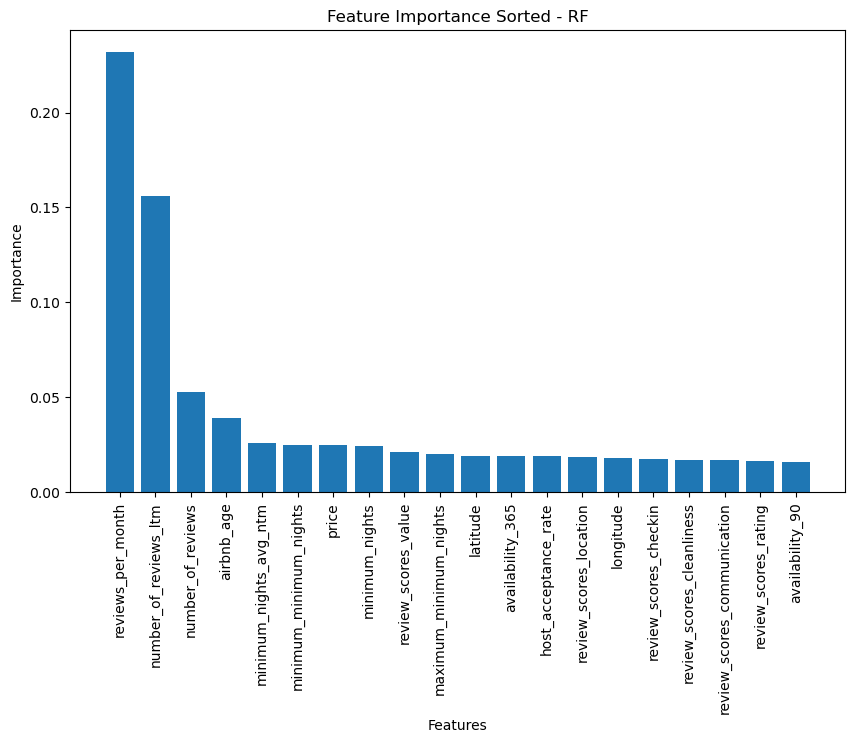

In [12]:
import pandas as pd

# 获取特征重要性
importance = model.feature_importances_
feature_names = X_train.columns

# 创建DataFrame并排序
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).iloc[:20,:]
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Sorted - RF')
plt.xticks(rotation='vertical')
plt.show()


In [13]:
# 使用randomgrid search
# 超参数搜索空间
param_distributions = {
    'n_estimators': [100, 200, 300, 500],  # 树的数量
    'max_features': ['sqrt', 'log2'],  # 寻找最佳分割时要考虑的特征数量
    'max_depth': [5, 10, 20, 30, 40, 50],  # 树的最大深度
    'min_samples_split': [2, 5, 10],  # 内部节点再划分所需最小样本数
    'min_samples_leaf': [1, 2, 4],  # 在叶节点上所需的最小样本数
    'bootstrap': [True, False]  # 是否在建立树时使用放回抽样
}

# 创建随机森林回归器实例
rf = RandomForestRegressor()

# 设置 RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=200,  # 进行100次抽样迭代
    cv=5,  # 5折交叉验证
    verbose=1,  # 显示详细信息
    random_state=42,  # 为了可重复性
    scoring='neg_mean_squared_error',  # 使用负均方误差作为评分标准
    n_jobs=-1  # 使用所有可用的CPU核心
)

# 训练模型
search.fit(X_train, y_train)

# 输出最佳参数和对应的性能
print("Best parameters:", search.best_params_)
print("Best score (MSE):", -search.best_score_)  # 转换成正的MSE，因为评分标准是负的MSE



Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Best score (MSE): 1.5880329365556904


In [14]:
# 基于超参数 ， train model
model = RandomForestRegressor(
**search.best_params_
)

# 在训练数据上拟合模型
model.fit(X_train, y_train)

# 使用测试数据进行预测
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 0.8801740156587236
MSE: 1.5172474510962533
RMSE: 1.231765988772321
R2 Square 0.5892320482235931
Train set evaluation:
_____________________________________
MAE: 0.0008919877085744531
MSE: 6.7000655536729926e-06
RMSE: 0.0025884484838746536
R2 Square 0.9999982192197101
